# Exploring Different Algorithms of Dominant Color Extraction

In the [AinaScan Project](https://www.ainascan.com) we have been exploring the classification of leaves into categories of "defective" and "healthy". These are extremely broad categories on purpose because the definition of what "defective" is could mean many things: disease, pests, deficiencies, algae, fungi, or all of the above. The goal is to quickly classify the leaves using a lightweight model so the defective leaves can be further analyzed by more sophisticated models.

One way we have been able to approach this is by classifying the leaf by its dominate color. Very simply, when manually annotating, it becomes very clear that simply the color of the leaf is a good indicator of its health. Blotches of yellow, brown, black, and even white could be many things, but for coffee, it is very often a defect!

In this notebook, we will explore two different algorithms and see which one is lightweight, fast, and accurate enough for our purposes!

## Extracting the Mask

First we need a leaf. Specifically, we need the mask of a diseased leaf. We can utilize a coffee disease dataset that I found on Kaggle as a test and pull some images from there. We can use a green mask filter to extract the leaf from the background. No need for a big ole instance segmentation model here! Had to play with the thresholds a bit, but it was pretty easy to get a good mask.

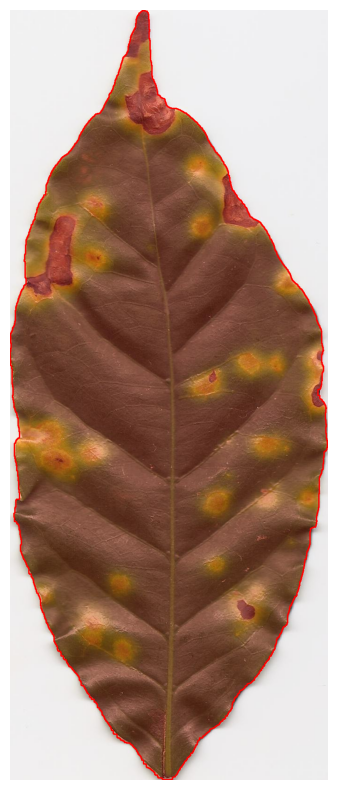

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

frame = cv2.imread('/home/jack/Mounts/DiskOne/kona_coffee/external/mendeley_rust_miner/rust/name39.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

lower_color = np.array([2, 40, 40])
upper_color = np.array([250, 255, 255])
    
mask = cv2.inRange(cv2.cvtColor(frame, cv2.COLOR_RGB2HSV), lower_color, upper_color)
mask = cv2.blur(mask, (11, 11))
mask = cv2.erode(mask, None, iterations=5)
mask[mask > 0] = 1

visual = frame.copy()

contour = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contour = max(contour, key=cv2.contourArea)

alpha = np.zeros_like(visual)
cv2.drawContours(alpha, [contour], -1, (255, 0, 0, 255), -1)
visual = cv2.addWeighted(visual, 1, alpha, 0.2, 0)
visual = cv2.drawContours(visual, [contour], -1, (255, 0, 0), 2)

bbox = cv2.boundingRect(contour)
cropped_mask = mask[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
cropped_frame = frame[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]

visual = visual[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]

plt.figure(figsize=(10, 10))
plt.imshow(visual)
plt.axis('off')
plt.show()

## Extracting the dominate Colors

Now that we have the mask, we can start extracting the dominate colors. There are a multitude of ways to do this but we can start off with a very niave approach and use the KMeans algorithm.

### KMeans Extraction

Everyone is familiar with KMeans (if your not I suggest you read about it! Very useful algorithm). Once we have the mask, we flatten the image and run it through the algorithm. KMeans gives us a list of centroids, which are the colors the algorithm converged on as segregated groups.

Elapsed 2.56 seconds


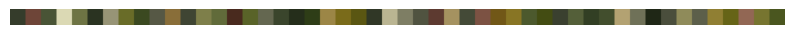

In [2]:
import time
from sklearn.cluster import KMeans

start_time = time.time()

# we only want to cluster the pixels inside the mask
x = cropped_frame[cropped_mask == 1]

# reshape to be 3 features: R, G, B
x = x.reshape(-1, 3) / 255

cluster = KMeans(n_clusters=50)
cluster.fit(x)

dominate_colors = cluster.cluster_centers_

print(f'Elapsed {time.time() - start_time:.2f} seconds')

colors_image = np.zeros((100, 100 * len(dominate_colors), 3), dtype=np.uint8)
for i, color in enumerate(dominate_colors):
    colors_image[:, i*100:(i+1)*100] = color * 255

plt.figure(figsize=(10, 10))
plt.imshow(colors_image)
plt.axis('off')
plt.show()

We can see that the dominate colors were certainly extracted. Many of the oranges, browns, and yellows from the mask are present which is the desired outcome. This is certainly a promising start! But at an estimated 2 seconds per image, this is not going to be fast enough for our purposes. This should be milliseconds, not seconds! Certainly, compression would help us achieve faster clustering time. We could also explore other clustering algorithms like the [Fiass](https://github.com/facebookresearch/faiss) library or try different distance metrics.

### Utilizing PIL to Compress the Image

The `Image` module in PIL has a `convert` method that actually has built in color quantization that we can take advantage of. Perhaps the library has already optimized the speed for us!

Elapsed 0.17 seconds


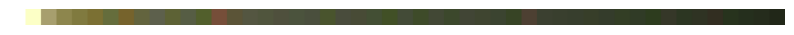

In [3]:
from PIL import Image

pil_image = cropped_frame.copy()

start_time = time.time()

# set the background to white. This is the best we can do to minimize including the background in the clustering
pil_image[np.logical_not(cropped_mask)] = 255
pil_image = Image.fromarray(pil_image)
paletted = pil_image.convert('P', palette=Image.ADAPTIVE, colors=50)
palette = paletted.getpalette()
color_idxs = paletted.getcolors()
dominate_colors = [palette[idx*3:idx*3+3] for _, idx in color_idxs]

print(f'Elapsed {time.time() - start_time:.2f} seconds')

colors_image = np.zeros((100, 100 * len(dominate_colors), 3), dtype=np.uint8)
for i, color in enumerate(dominate_colors):
    colors_image[:, i*100:(i+1)*100] = color

plt.figure(figsize=(10, 10))
plt.imshow(colors_image)
plt.axis('off')
plt.show()

Wow! Certainly the speed is much faster at around 0.15 seconds per image. But, since we don't have a way to only include the colors within the mask, the colors given include the white background. This is not ideal, but it is certainly something that regularization can account for when we are training our model. As these white colors don't really mean anything, we hope a model can learn to ignore them. Further, the colors that are included within the dominates are much more muted than the KMeans approach. Without fine tuning a model, it is hard to say if this is a good or bad thing. Sometimes what we can visualize is not always something the model needs to learn the patterns.

## Training A Model on the Extracted Colors

Now that we have established our methods of extraction, we can train a model on these features and see which one tends to perform better. We need a lot more data to do this, but fortunately I have already done this with the dataset. We can load the data, extract the features with the two methods, and train a simple model to see which one performs better. This process is very computationally heavy, so I am resizing the images and utilizing a threadpool to speed up the process.

In [148]:
import pandas as pd

df = pd.read_parquet('dataset.parquet')

source_dir = df.iloc[0].source_dir

df = df.drop(columns=['source_dir'])

df

,image,contour,defect,defective
3015,miner/41.jpg,"[1147, 241, 1146, 242, 1142, 242, 1141, 243, 1...",miner,True
4698,phoma/279.jpg,"[1056, 88, 1055, 89, 1043, 89, 1042, 90, 1034,...",phoma,True
5404,rust/1579.jpg,"[1202, 186, 1201, 187, 1194, 187, 1193, 188, 1...",rust,True
6309,phoma/551.jpg,"[1284, 229, 1283, 230, 1279, 230, 1278, 231, 1...",phoma,True
4456,phoma/320.jpg,"[331, 226, 330, 227, 330, 237, 331, 238, 331, ...",phoma,True
...,...,...,...,...
6194,nodisease/1197.jpg,"[958, 141, 957, 142, 944, 142, 943, 143, 936, ...",nodisease,False
6195,nodisease/1197.jpg,"[958, 141, 957, 142, 944, 142, 943, 143, 936, ...",nodisease,False
6197,nodisease/1209.jpg,"[1010, 154, 1009, 155, 1001, 155, 1000, 156, 9...",nodisease,False
6198,nodisease/1209.jpg,"[1010, 154, 1009, 155, 1001, 155, 1000, 156, 9...",nodisease,False


In [149]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_features(row):
    image_path = f'{source_dir}/{row.image}'
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    contour = np.array(row.contour).reshape(-1, 2)
    
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 1, -1)
    
    bbox = cv2.boundingRect(contour)
    frame = frame[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    mask = mask[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    
    # resize to 512x512 for faster computation
    frame = cv2.resize(frame, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    
    # kmeans clustering
    x = frame[mask == 1]
    x = x.reshape(-1, 3) / 255
    model = KMeans(n_clusters=50)
    model.fit(x)
    kmeans_dominate_colors = model.cluster_centers_
    
    # PIL computation
    pil_image = frame
    pil_image[np.logical_not(mask)] = 255
    pil_image = Image.fromarray(pil_image)
    paletted = pil_image.convert('P', palette=Image.ADAPTIVE, colors=50)
    palette = paletted.getpalette()
    color_idxs = paletted.getcolors()
    pil_dominate_colors = np.array([palette[idx*3:idx*3+3] for _, idx in color_idxs]) / 255

    return pil_dominate_colors.flatten(), kmeans_dominate_colors.flatten()


pool = ThreadPoolExecutor(8)
futures = []
columns = []

loader = tqdm(total=len(df), desc='Processing Frames')

for row in df.itertuples():
    futures.append(pool.submit(get_features, row))

for future in as_completed(futures):
    loader.update(1)
    columns.append(future.result())
columns = np.array(columns)

loader.close()

df['pil_method'] = list(columns[:, 0])
df['kmeans_method'] = list(columns[:, 1])

df.to_parquet('features.parquet')

Processing Frames: 100%|██████████| 1694/1694 [05:01<00:00,  5.62it/s]


Very expensive operation. But we make sure to save it so we don't have to do that again. We can take a look at the two groups by building an image of a sample set of the colors and look at them side by side.

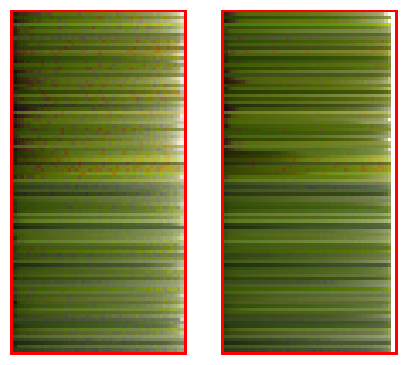

In [70]:
sample_size = 100
features = 50

s1 = df[df.defective==True].sample(sample_size // 2)
s2 = df[df.defective==False].sample(sample_size // 2)

samples = pd.concat([s1, s2])

shape = (sample_size, features, 3)

pil_colors = np.zeros(shape, dtype=np.uint8)
kms_colors = np.zeros(shape, dtype=np.uint8)

for y, row in enumerate(samples.itertuples()):
    pil_method = np.array(row.pil_method).reshape(-1, 3) * 255
    kms_method = np.array(row.kmeans_method).reshape(-1, 3) * 255

    # We sort the colors by their norm to make the comparison easier to distinguish
    # This gives less randomness to the order of the colors, 
    pil_method = pil_method[np.argsort(np.linalg.norm(pil_method, axis=1))]
    kms_method = kms_method[np.argsort(np.linalg.norm(kms_method, axis=1))]

    for x in range(features):
        pil_colors[y:y+1, x:(x+1)] = pil_method[x]
        kms_colors[y:y+1, x:(x+1)] = kms_method[x]

pil_colors = cv2.copyMakeBorder(pil_colors, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=255)
kms_colors = cv2.copyMakeBorder(kms_colors, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=255)

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(kms_colors)
ax[0].axis('off')
ax[1].imshow(pil_colors)
ax[1].axis('off')
plt.show()

With the top being defective leafs, and the bottom only healthy leaves, we can see that the Kmeans approach is very different than the PIL approach when visualizing the results side by side. The Kmeans approach seems to pickup on a lot more of the defect colors (the browns and oranges), where as the PIL approach seems to filter out a lot more of those colors. Intuitively, we need our feature extractor to pick up on even minor color changes if we are have a very sensitive model. This would logically suggest that KMeans would be the better approach, but we can't know for sure until we train a model.

We will start with a Logistic Regression model as it is the de-facto standard base classification model to explore.

In [64]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, confusion_matrix
import seaborn as sns

sns.set_theme(style='whitegrid')

def plot_classifier(model, x_test, y_test, title):
    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred)

    # plot precision recall curve
    proba = model.predict_proba(x_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, proba)
    fpr, tpr, _ = roc_curve(y_test, proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # padding at top
    plt.subplots_adjust(top=0.85)
    
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])

    ax[1].plot(recall, precision, color='b')
    ax[1].fill_between(recall, precision, alpha=0.2, color='b')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision Recall Curve')

    ax[2].plot(fpr, tpr, color='b')
    ax[2].fill_between(fpr, tpr, alpha=0.2, color='b')
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('ROC Curve')

    plt.suptitle(f'{title} | F1 {f1:.2f}')
    plt.show()

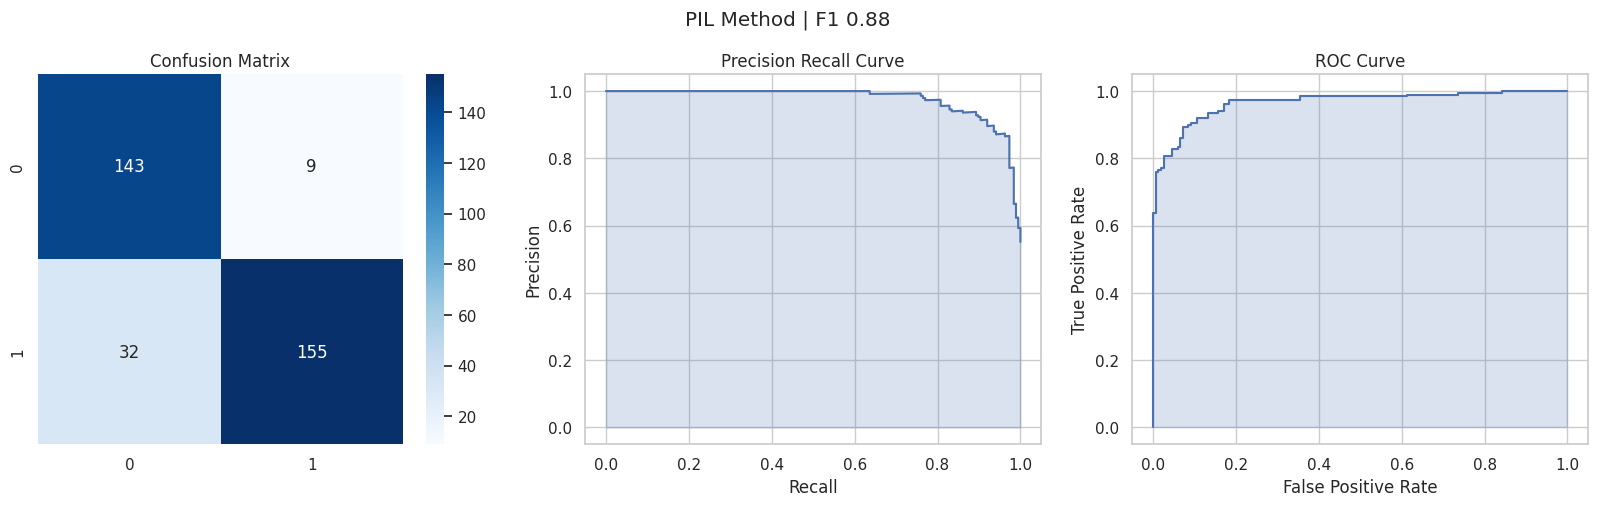

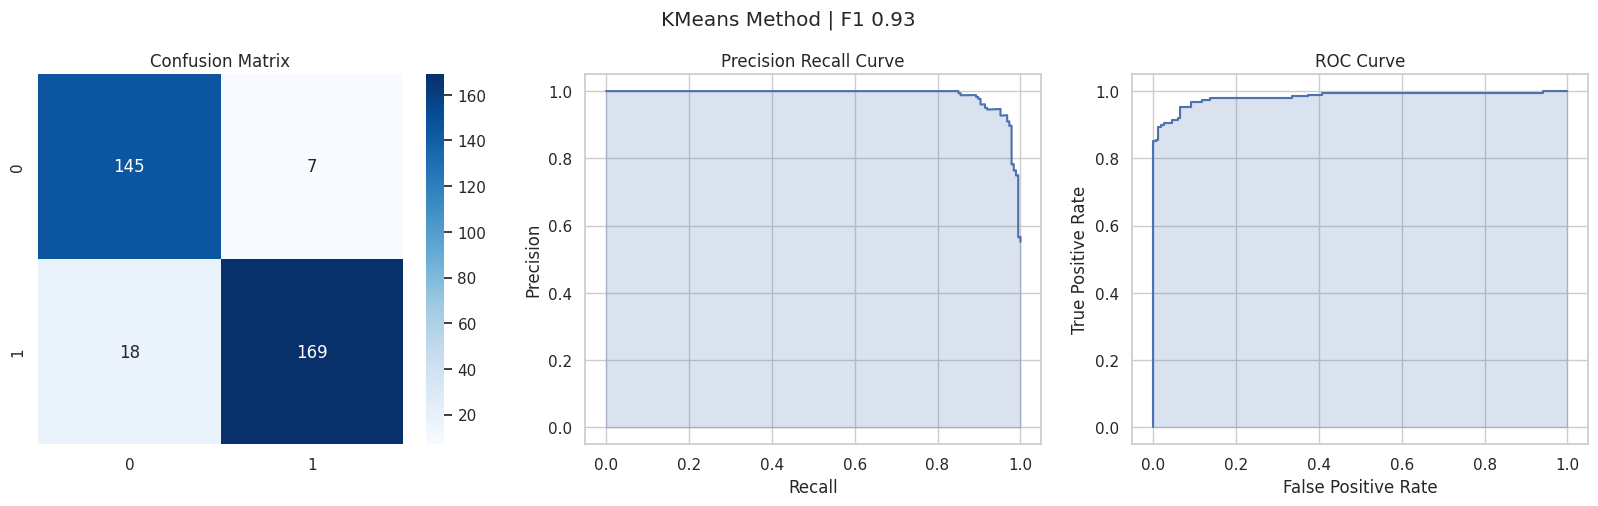

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

df = df.reset_index()

model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression())
])

y = df['defective'].astype(int)

x = df.pil_method.apply(lambda x: np.array(x).reshape(-1, 3) * 255)
x = np.array(x.apply(lambda x: x[np.argsort(np.linalg.norm(x, axis=1))]).tolist()).reshape(-1, 150)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model.fit(x_train, y_train)
plot_classifier(model, x_test, y_test, 'PIL Method')

x = df.kmeans_method.apply(lambda x: np.array(x).reshape(-1, 3) * 255)
x = np.array(x.apply(lambda x: x[np.argsort(np.linalg.norm(x, axis=1))]).tolist()).reshape(-1, 150)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model.fit(x_train, y_train)
plot_classifier(model, x_test, y_test, 'KMeans Method')

Even though I somewhat doubted the method, the PIL approach actually performed quite well in comparison to the KMeans approach. Both approaches give us nearly 0.9 F1 score, but it's clear the PIL approach has many more false positives.

We could explore other models, and other scoring methodologies. Further, we can add more data as we do have a rather small dataset to work with. But if this was the production dataset we had to work with and no further tests were conducted, we could conclude that the PIL method does degrade accuracy slightly (but is much faster and more lightweight). Have to pick your poison!

## Conclusion

A few notes that are important to consider that we explored in this notebook:

- This is a very basic binary classification problem: why not just utilize a convolutional neural network? CNN's are very computationally expensive and typically require GPU's to run. Would it not save your organization thousands on cloud GPU's if you could solve the problem (with 90% accuracy) with a simple logisitic regression model? 

- Utilizing the PIL library to extract features, we went from 2.5 seconds per image to 0.15 seconds per image: a 17x speedup! This is a huge improvement and could be the difference between a model that can be run on a local machine versus a model that requires a cloud GPU. We can save costs and time for our organization and for our users.

- Yes we can classify healthy and defective leaves with a very simple model. We just need an intelligent feature extractor and also understand the domain we are working in. We could utilize a CNN to extract features automatically, but at the cost of speed and complexity.

- We shouldn't underestimate the power of simplicity. With this approach, we have a simplistic model where the internals are easy to explain. We can dive into the feature space and understand why the model is making the decisions it makes. In this case, it could very well be important to understand why a leaf is classified as defective.

- Finally, although intuition and logic may be great at helping us make decisions, it shouldn't nessesarily be the decision maker. We initiually thought that the PIL approach would be worse than the KMeans approach (admittedly I thought it would be much worse), but the results were clear that the PIL approach was only slightly worse. With more data, more tuning, and using a series of oversamplings and cross validation, we may even show that the PIL approach could be equal or even better than the KMeans approach! Statistics is very fascinating in that way.